In [1]:
import torch
from model import LUNet
from matplotlib import pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import StepLR
from train import training_routine_gaussian, training_routine_uniform, training_routine_uniform_method2
from test import testing_routine
from functions import uniform_circle_log_likelihood, uniform_circle_log_likelihood_method2, gaussian_loss_function

from pathlib import Path

from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density, compute_gaussian_density

In [2]:
torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

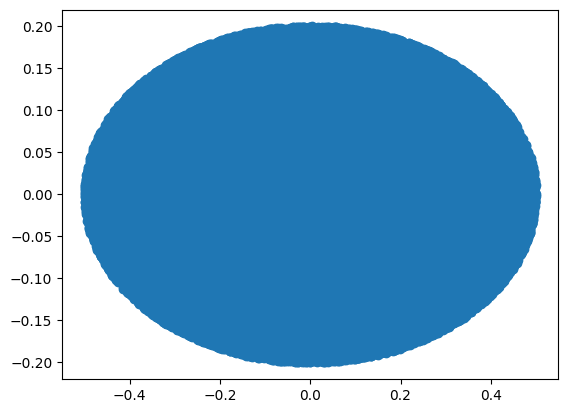

In [3]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

training_set = generate_ellipse(max_num=100000, scale=(0.5,0.2), device=device)
validation_set = generate_ellipse(max_num=10000, scale=(0.5,0.2), device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

In [4]:
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [63]:
model = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [64]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [65]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:02, 28.02it/s]
62it [00:00, 127.05it/s]


Test set: Average loss: 84.7658


77it [00:02, 30.94it/s]
62it [00:00, 127.14it/s]


Test set: Average loss: 457.4422


77it [00:02, 30.73it/s]
62it [00:00, 127.04it/s]


Test set: Average loss: 448.6270


77it [00:02, 31.32it/s]
62it [00:00, 128.36it/s]


Test set: Average loss: -19.3037


77it [00:02, 30.58it/s]
62it [00:00, 127.05it/s]


Test set: Average loss: 336.3557


77it [00:02, 30.58it/s]
62it [00:00, 128.89it/s]


Test set: Average loss: -83.1680


77it [00:02, 31.79it/s]
62it [00:00, 128.62it/s]


Test set: Average loss: -39.0613


77it [00:02, 30.65it/s]
62it [00:00, 128.62it/s]


Test set: Average loss: 300.2539


77it [00:02, 30.84it/s]
62it [00:00, 123.50it/s]


Test set: Average loss: -163.6860


77it [00:02, 31.58it/s]
62it [00:00, 122.76it/s]


Test set: Average loss: -167.5888


77it [00:02, 31.24it/s]
62it [00:00, 127.04it/s]


Test set: Average loss: -183.3244


77it [00:02, 31.52it/s]
62it [00:00, 124.74it/s]


Test set: Average loss: -168.3418


77it [00:02, 31.67it/s]
62it [00:00, 128.09it/s]


Test set: Average loss: -28.5601


77it [00:02, 29.98it/s]
62it [00:00, 128.09it/s]


Test set: Average loss: -206.6955


77it [00:02, 30.52it/s]
62it [00:00, 127.84it/s]


Test set: Average loss: -182.6197


77it [00:02, 30.75it/s]
62it [00:00, 128.90it/s]


Test set: Average loss: -127.9901


77it [00:02, 29.98it/s]
62it [00:00, 127.18it/s]


Test set: Average loss: -257.8334


77it [00:02, 30.78it/s]
62it [00:00, 128.62it/s]


Test set: Average loss: -250.5449


77it [00:02, 30.36it/s]
62it [00:00, 128.36it/s]


Test set: Average loss: -233.9583


77it [00:02, 30.74it/s]
62it [00:00, 125.00it/s]

Test set: Average loss: -257.1594
CPU times: total: 1min 49s
Wall time: 60 s


0

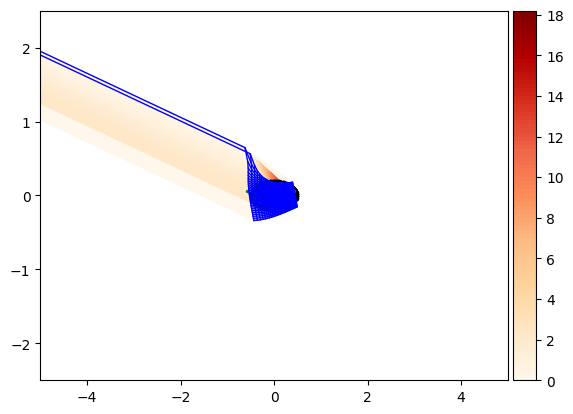

In [69]:
scale=10
factor=0.94

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

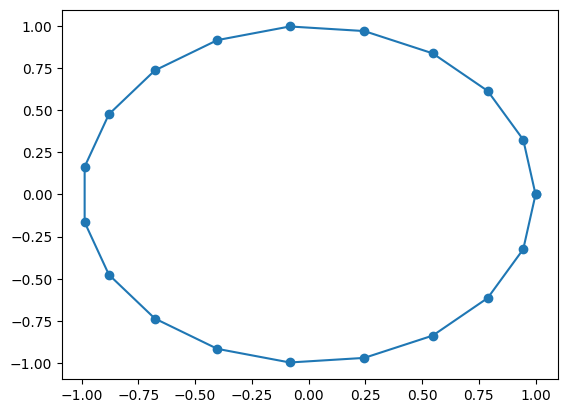

In [96]:
def generate_circle_grid(n_grid_points = 20, n_layers=1):
    angles = np.linspace(0, 2*np.pi, n_grid_points)
    circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
    circles = [np.stack((np.cos(angles), np.sin(angles)), axis=1)*s for s in np.linspace(0.1,1,n_layers)]
    grid_points = np.concatenate(circles)
    return grid_points

def generate_circle_grid(n_grid_points = 20):
    angles = np.linspace(0, 2*np.pi, n_grid_points)
    circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
    return circle

grid_points = generate_circle_grid(n_grid_points = 20)

#plt.scatter(circle[:,0], circle[:,1])
for circle in np.split(grid_points, 1):
    plt.plot(circle[:,0], circle[:,1], '-o')

In [109]:
import torch
from functions import gaussian_loss_function, uniform_circle_log_likelihood, uniform_circle_log_likelihood_method2
from tqdm import tqdm
# from visuals import add_batch_loss
from torch import nn
from model import register_activation_hooks, remove_activation_hooks

def grid_loss(circle):
    diff = torch.diff(torch.concatenate((circle, circle[:1])), axis=0)
    distances = torch.sum(torch.abs(diff), axis=1) # metric induced by 1-norm
    return torch.sum(distances)

def training_routine_uniform_method2(model, train_loader, optimizer,
                                     loss_function=uniform_circle_log_likelihood_method2, grid_penalty=False,
                                     grid_input=None, penalty_weight=1e-3):
    model.train()
    train_loss = 0

    """outputs of L-layer are needed for the loss function"""
    layers = []
    for j in range(len(model.intermediate_lu_blocks)):
        if j % 2 != 0:
            layers.append("intermediate_lu_blocks.{}".format(j))
    layers.append("final_lu_block.1")

    for i, input in tqdm(enumerate(train_loader)):
        optimizer.zero_grad(set_to_none=True)
        loss = 0
        ###
        # SECOND GRID INPUT AND ADD TO LOSS FUNCTION
        if grid_penalty:
            grid_output = model(grid_input, reverse=True)
            loss += penalty_weight * grid_loss(grid_output)
            print(loss)
        ###
        saved_layers, handles = register_activation_hooks(model, layers_to_save=layers)
        output = model(input)
        loss += loss_function(output, model, saved_layers)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=1)
        optimizer.step()
        loss = loss.detach()
        train_loss += loss
        remove_activation_hooks(handles)


In [110]:
%%time

train_with_grid_penalty = True

grid_input = torch.tensor(grid_points, device=device, requires_grad=False)

for epoch in range(1, 5):
    training_routine_uniform_method2(model, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2, 
                                    grid_penalty=train_with_grid_penalty, grid_input=grid_input, penalty_weight=0.001)
    testing_routine(model, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

1it [00:00,  2.46it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


2it [00:00,  2.79it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


3it [00:01,  2.97it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


4it [00:01,  3.04it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


5it [00:01,  3.14it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


6it [00:01,  3.24it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


7it [00:02,  3.30it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


8it [00:02,  3.35it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


9it [00:02,  3.39it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


10it [00:03,  3.42it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


11it [00:03,  3.41it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


12it [00:03,  3.44it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


13it [00:03,  3.47it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


14it [00:04,  3.21it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


15it [00:04,  3.43it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


16it [00:04,  3.60it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


17it [00:05,  3.72it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


18it [00:05,  3.81it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


19it [00:05,  3.75it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


20it [00:05,  3.82it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


21it [00:06,  3.88it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


22it [00:06,  3.88it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


23it [00:06,  3.87it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


24it [00:06,  3.85it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


25it [00:07,  3.85it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


26it [00:07,  3.80it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


27it [00:07,  3.79it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


28it [00:08,  3.47it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


29it [00:08,  3.57it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


30it [00:08,  3.74it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


31it [00:08,  3.86it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


32it [00:08,  3.97it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


33it [00:09,  4.06it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


34it [00:09,  4.10it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


35it [00:09,  4.15it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


36it [00:09,  4.17it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


37it [00:10,  4.04it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


38it [00:10,  3.85it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


39it [00:10,  3.73it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


40it [00:11,  3.68it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


41it [00:11,  3.66it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


42it [00:11,  3.78it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


43it [00:11,  3.87it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


44it [00:12,  3.94it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


45it [00:12,  3.95it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


46it [00:12,  3.99it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


47it [00:12,  4.02it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


48it [00:13,  3.99it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


49it [00:13,  3.93it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


50it [00:13,  3.90it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


51it [00:13,  3.58it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


52it [00:14,  3.67it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


53it [00:14,  3.77it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


54it [00:14,  3.80it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


55it [00:14,  3.81it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


56it [00:15,  3.77it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


57it [00:15,  3.84it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


58it [00:15,  3.76it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


59it [00:16,  3.69it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


60it [00:16,  3.73it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


61it [00:16,  3.74it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


62it [00:16,  3.88it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


63it [00:17,  3.91it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


64it [00:17,  3.88it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


65it [00:17,  3.89it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


66it [00:17,  3.91it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


67it [00:18,  3.85it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


68it [00:18,  3.77it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


69it [00:18,  3.77it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


70it [00:18,  3.81it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


71it [00:19,  3.78it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


72it [00:19,  3.88it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


73it [00:19,  3.95it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


74it [00:19,  4.01it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


75it [00:20,  3.95it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


76it [00:20,  3.90it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


77it [00:20,  3.73it/s]


tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


62it [00:00, 122.53it/s]


Test set: Average loss: -279.2197


0it [00:00, ?it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)

1it [00:00,  4.24it/s]

2it [00:00,  4.15it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


3it [00:00,  4.21it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


4it [00:00,  4.21it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


5it [00:01,  4.20it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


6it [00:01,  4.02it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


7it [00:01,  3.95it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


8it [00:01,  3.86it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


9it [00:02,  3.81it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


10it [00:02,  3.74it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


11it [00:02,  3.37it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


12it [00:03,  3.37it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


13it [00:03,  3.54it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


14it [00:03,  3.55it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


15it [00:03,  3.61it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


16it [00:04,  3.66it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


17it [00:04,  3.81it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


18it [00:04,  3.82it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


19it [00:05,  3.82it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


20it [00:05,  3.82it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


21it [00:05,  3.87it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


22it [00:05,  3.81it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


23it [00:06,  3.83it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


24it [00:06,  3.89it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


25it [00:06,  3.94it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


26it [00:06,  3.93it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


27it [00:07,  3.74it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


28it [00:07,  3.83it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


29it [00:07,  3.95it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


30it [00:07,  4.01it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


31it [00:08,  4.00it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


32it [00:08,  3.93it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


33it [00:08,  4.01it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


34it [00:08,  4.07it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


35it [00:09,  4.08it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


36it [00:09,  4.03it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


37it [00:09,  4.00it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


38it [00:09,  3.93it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


39it [00:10,  3.91it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


40it [00:10,  3.85it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


41it [00:10,  3.82it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


42it [00:10,  3.79it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


43it [00:11,  3.68it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


44it [00:11,  3.67it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


45it [00:11,  3.59it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


46it [00:12,  3.57it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


47it [00:12,  3.54it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


48it [00:12,  3.51it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


49it [00:12,  3.48it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


50it [00:13,  3.50it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


51it [00:13,  3.51it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


52it [00:13,  3.51it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


53it [00:14,  3.48it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


54it [00:14,  3.47it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


55it [00:14,  3.51it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


56it [00:14,  3.57it/s]

tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)


57it [00:15,  3.56it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


58it [00:15,  3.59it/s]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


59it [00:15,  3.53it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


60it [00:16,  3.41it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


61it [00:16,  3.44it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


62it [00:16,  3.56it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


63it [00:16,  3.70it/s]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


64it [00:17,  3.64it/s]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


65it [00:17,  3.74it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


66it [00:17,  3.76it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


67it [00:17,  3.85it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


68it [00:18,  3.83it/s]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


69it [00:18,  3.93it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


70it [00:18,  3.99it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


71it [00:18,  4.01it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


72it [00:19,  3.94it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


73it [00:19,  3.90it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


74it [00:19,  3.85it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


75it [00:19,  3.78it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


76it [00:20,  3.74it/s]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


77it [00:20,  3.76it/s]


tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


62it [00:00, 99.10it/s] 


Test set: Average loss: -266.2537


1it [00:00,  3.79it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


2it [00:00,  3.75it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


3it [00:00,  3.87it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


4it [00:01,  4.01it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


5it [00:01,  4.09it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


6it [00:01,  4.09it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


7it [00:01,  4.08it/s]

tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>)


8it [00:01,  4.07it/s]

tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)


9it [00:02,  3.97it/s]

tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

0

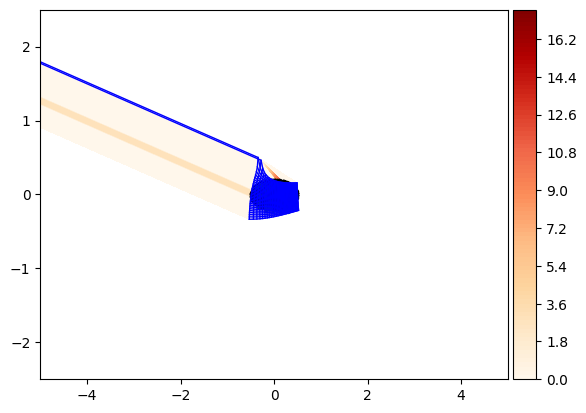

In [81]:
scale=10
factor=0.99

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

In [248]:
import torch
from functions import lifted_sigmoid
from model import register_activation_hooks, remove_activation_hooks
import numpy as np

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import pyplot as plt

def uniform_circle_likelihoods(output, model, layers, device):
    """compute the log likelihood with change of variables formula, average per pixel"""
    N, D = output.shape  # batch size and single output size

    uniform = torch.zeros(output.shape[0], device=device)
    dist = torch.square(output)
    dist = torch.sum(dist, axis=1) ** 0.5
    uniform[torch.where(dist > 1)] = 10

    """Third summand"""
    """log diagonals of U"""
    log_diagonals_triu = []
    for param in model.parameters():
        if len(param.shape) == 2 and param[1, 0] == 0:  # if upper triangular and matrix
            log_diagonals_triu.append(torch.log(torch.abs(torch.diag(param))))

    log_derivatives = []
    for i in range((len(layers) - 1) * 2):
        """layers are outputs of the L-Layer"""
        """lifted sigmoid = derivative of leaky softplus"""
        if i % 2 != 0:
            log_derivatives.append(
                torch.log(torch.abs(lifted_sigmoid(layers["intermediate_lu_blocks.{}".format(i)][0]))))
    log_derivatives.append(torch.log(torch.abs(lifted_sigmoid(layers["final_lu_block.1"][0]))))

    """lu-blocks 1,...,M-1"""
    summand = torch.zeros(N, D).to("cuda:0")
    for l in range(len(log_diagonals_triu) - 1):
        summand = summand + log_derivatives[l]
        summand = summand + log_diagonals_triu[l]

    """lu-block M"""
    last = log_diagonals_triu[len(log_diagonals_triu) - 1]
    # print(last, summand, sum_uniform)
    last = torch.sum(last)
    # summand = summand + last # equivalent, last determinant of last layer applies for all rows of batch

    output = uniform - last - summand.sum(axis=1)

    return np.e ** np.array(-output.to('cpu'))


def compute_uniform_circle_density(model, grid_points, device):
    """outputs of L-layer are needed for the loss function"""
    layers = []
    for j in range(len(model.intermediate_lu_blocks)):
        if j % 2 != 0:
            layers.append("intermediate_lu_blocks.{}".format(j))
    layers.append("final_lu_block.1")

    with torch.no_grad():
        saved_layers, handles = register_activation_hooks(model, layers_to_save=layers)
        grid_points = grid_points.clone().to(device)
        output = model(grid_points)
        density = uniform_circle_likelihoods(output, model, saved_layers, device)
        remove_activation_hooks(handles)
    return density


def plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width,
                                      x_range=(-1.5, 1.5), y_range=(-1.5, 1.5), x_lim=(-1, 1), y_lim=(-1, 1),
                                      density_function=compute_uniform_circle_density):
    fig, ax = plt.subplots()

    plt.xlim(*x_lim)
    plt.ylim(*y_lim)

    x = np.linspace(*x_range, grid_width)
    y = np.linspace(*y_range, grid_width)

    xv, yv = np.meshgrid(x, y, indexing='xy')
    horizontal_lines = np.stack((xv, yv), axis=2)

    xv, yv = np.meshgrid(x, y, indexing='ij')
    vertical_lines = np.stack((xv, yv), axis=2)  # vertical_lines

    all_grid_points = np.concatenate(np.concatenate((horizontal_lines, vertical_lines)), axis=0)
    all_grid_points = torch.tensor(all_grid_points, device=device)

    t = model(all_grid_points, reverse=True).detach()
    t = t.to('cpu')
    t = t.numpy()
    temp_t = t[:t.shape[0] // 2]
    x = np.array(temp_t)[:, 0]
    y = np.array(temp_t)[:, 1]
    z = density_function(model, torch.tensor(temp_t, device=device), device)
    
    horizontal_transformed, vertical_transformed = np.split(np.array(t), 2)

    for h in np.split(horizontal_transformed, grid_width):
        ax.plot(h[:, 0], h[:, 1], c='grey', linewidth=1.)

    for v in np.split(vertical_transformed, grid_width):
        ax.plot(v[:, 0], v[:, 1], c='grey', linewidth=1.)
        
    cntr2 = ax.tricontourf(x, y, z, levels=100, cmap="OrRd")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cntr2, cax=cax)


    inner_grid_points = torch.tensor(generate_circle_grid(2000), device=device, requires_grad=False)
    inner_grid_points = model(inner_grid_points, reverse=True).detach().to('cpu')
    circle = np.array(inner_grid_points)
    ax.plot(circle[:,0], circle[:,1], '-', linewidth=3., c='blue')
    print(circle)


    ax.scatter(train_loader[:, 0][:3200], train_loader[:, 1][:3200], c='black', alpha=1, s=2)
    output = model(torch.tensor(sampling_data, device=device), reverse=True)
    output = output.to('cpu').detach().numpy()
    ax.scatter(np.array(output)[:, 0], np.array(output)[:, 1], c='green', alpha=1, s=2)

    return 0


C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\1691596503.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

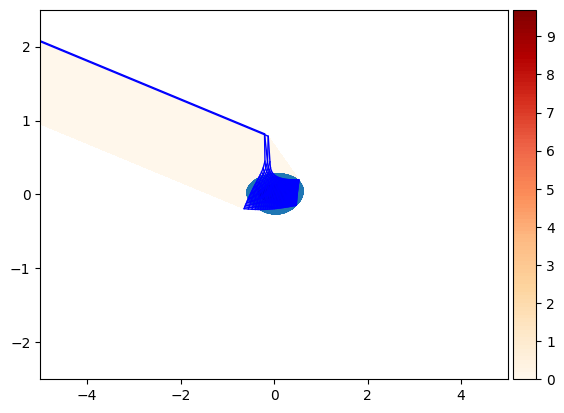

In [113]:
scale=10
factor=0.98

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\3381806200.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

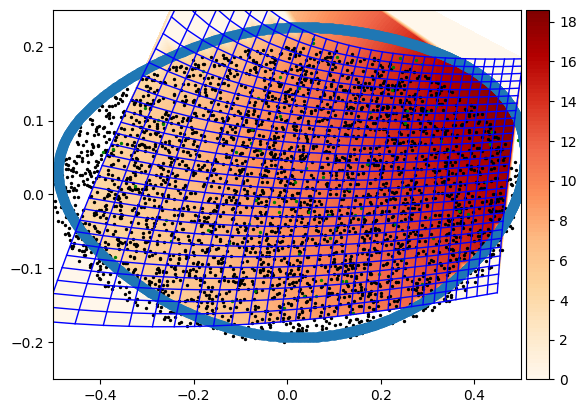

In [124]:
scale=1
factor=0.9

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

## Reduce Complexity of Model

In [125]:
model = LUNet(num_lu_blocks=3, layer_size = 2).to(device)

In [127]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [151]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:01, 62.89it/s]
62it [00:00, 352.27it/s]


Test set: Average loss: -278.3642


77it [00:01, 76.39it/s]
62it [00:00, 337.86it/s]


Test set: Average loss: -280.1294


77it [00:01, 71.69it/s]
62it [00:00, 340.66it/s]


Test set: Average loss: -284.2011


77it [00:01, 70.06it/s]
62it [00:00, 344.45it/s]


Test set: Average loss: -290.4736


77it [00:01, 70.06it/s]
62it [00:00, 346.37it/s]


Test set: Average loss: -282.1830


77it [00:01, 69.31it/s]
62it [00:00, 346.37it/s]


Test set: Average loss: -282.2521


77it [00:01, 69.37it/s]
62it [00:00, 348.32it/s]


Test set: Average loss: -281.1090


77it [00:01, 70.44it/s]
62it [00:00, 336.96it/s]


Test set: Average loss: -274.9575


77it [00:01, 69.37it/s]
62it [00:00, 342.54it/s]


Test set: Average loss: -283.1233


77it [00:01, 69.87it/s]
62it [00:00, 348.32it/s]


Test set: Average loss: -193.4164


77it [00:01, 73.75it/s]
62it [00:00, 346.37it/s]


Test set: Average loss: -277.7404


77it [00:01, 74.93it/s]
62it [00:00, 346.36it/s]


Test set: Average loss: -267.2979


77it [00:01, 72.44it/s]
62it [00:00, 340.66it/s]


Test set: Average loss: -284.7367


77it [00:01, 76.60it/s]
62it [00:00, 344.45it/s]


Test set: Average loss: -287.3686


77it [00:01, 72.78it/s]
62it [00:00, 317.89it/s]


Test set: Average loss: -279.8822


77it [00:01, 70.38it/s]
62it [00:00, 338.80it/s]


Test set: Average loss: -290.4911


77it [00:01, 72.71it/s]
62it [00:00, 333.30it/s]


Test set: Average loss: -285.3482


77it [00:01, 75.12it/s]
62it [00:00, 346.37it/s]


Test set: Average loss: -279.2143


77it [00:01, 71.55it/s]
62it [00:00, 340.66it/s]


Test set: Average loss: -284.6179


77it [00:01, 76.01it/s]
62it [00:00, 354.29it/s]

Test set: Average loss: -286.3389
CPU times: total: 1min 13s
Wall time: 25.2 s


C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\4117882673.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

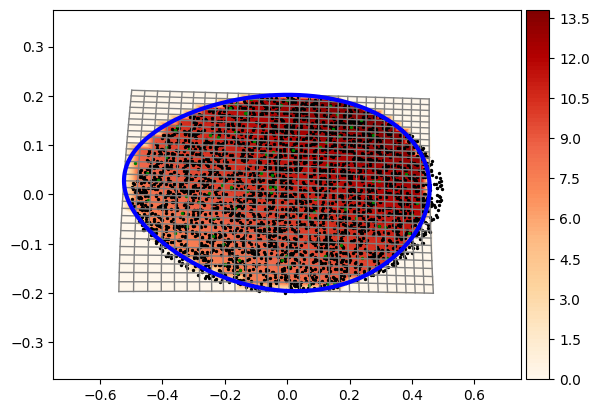

In [152]:
scale=1.5
factor=1

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

## Banana Data!

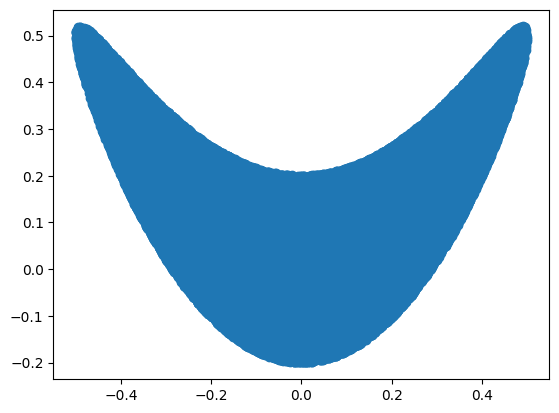

In [164]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
training_set = generate_banana(n=100000, device=device)
validation_set = generate_banana(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [184]:
model_banana = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [222]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=0.008, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [225]:
scheduler.get_last_lr()

[0.006543255500777845]

In [226]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model_banana, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_banana, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:02, 25.71it/s]
62it [00:00, 90.91it/s]


Test set: Average loss: -268.8332


77it [00:02, 25.83it/s]
62it [00:00, 91.58it/s]


Test set: Average loss: -269.3055


77it [00:02, 25.68it/s]
62it [00:00, 91.99it/s]


Test set: Average loss: -266.6219


77it [00:03, 25.61it/s]
62it [00:00, 90.91it/s]


Test set: Average loss: -268.8290


77it [00:03, 25.03it/s]
62it [00:00, 88.83it/s]


Test set: Average loss: -267.3950


77it [00:03, 25.58it/s]
62it [00:00, 93.23it/s] 


Test set: Average loss: -268.8550


77it [00:03, 25.36it/s]
62it [00:00, 95.24it/s] 


Test set: Average loss: -265.5067


77it [00:03, 24.94it/s]
62it [00:00, 96.72it/s] 


Test set: Average loss: -269.4038


77it [00:03, 24.89it/s]
62it [00:00, 103.30it/s]


Test set: Average loss: -268.3233


77it [00:02, 28.00it/s]
62it [00:00, 127.31it/s]


Test set: Average loss: -269.4851


77it [00:02, 31.19it/s]
62it [00:00, 125.48it/s]


Test set: Average loss: -268.3793


77it [00:02, 30.45it/s]
62it [00:00, 126.52it/s]


Test set: Average loss: -267.7699


77it [00:02, 31.18it/s]
62it [00:00, 129.21it/s]


Test set: Average loss: -268.6451


77it [00:02, 30.61it/s]
62it [00:00, 127.84it/s]


Test set: Average loss: -269.1633


77it [00:02, 30.85it/s]
62it [00:00, 126.78it/s]


Test set: Average loss: -267.9856


77it [00:02, 30.97it/s]
62it [00:00, 126.27it/s]


Test set: Average loss: -270.6215


77it [00:02, 30.57it/s]
62it [00:00, 128.89it/s]


Test set: Average loss: -269.0340


77it [00:02, 30.14it/s]
62it [00:00, 123.51it/s]


Test set: Average loss: -270.3364


77it [00:02, 31.75it/s]
62it [00:00, 126.52it/s]


Test set: Average loss: -268.4900


77it [00:02, 30.46it/s]
62it [00:00, 124.00it/s]

Test set: Average loss: -269.7028
CPU times: total: 1min 49s
Wall time: 1min 6s


C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\4117882673.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

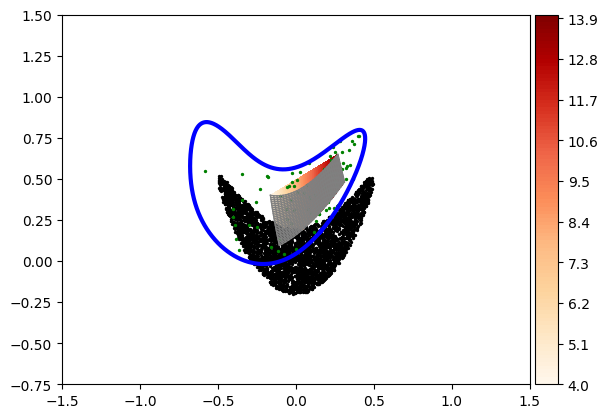

In [188]:
scale=3
factor=0.5

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\4117882673.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

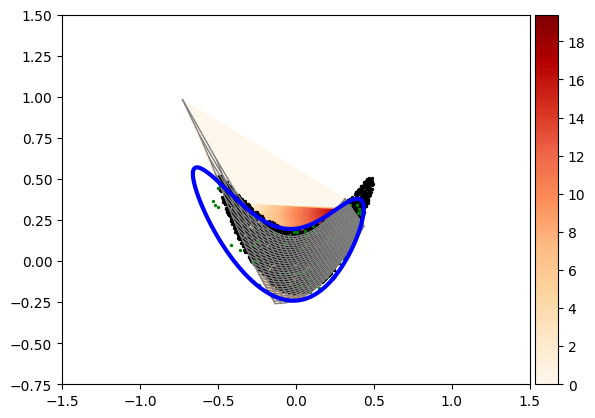

In [196]:
scale=3
factor=0.8

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\4117882673.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

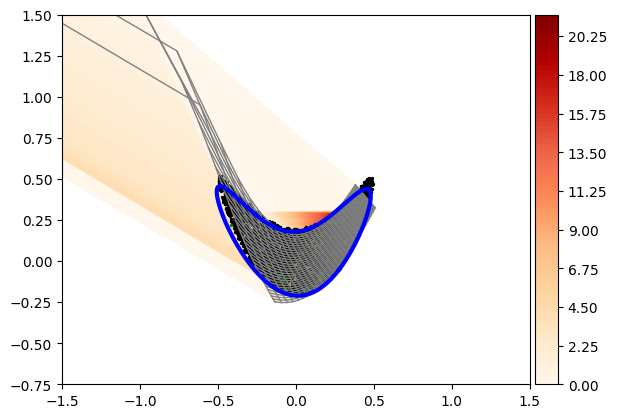

In [199]:
scale=3
factor=0.9

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\4117882673.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

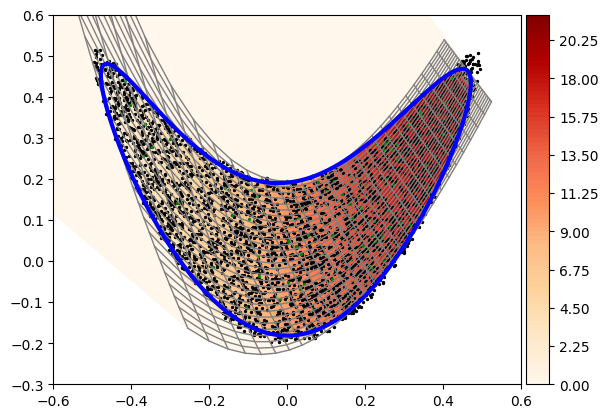

In [227]:
scale=1.2
factor=1

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

## Welle

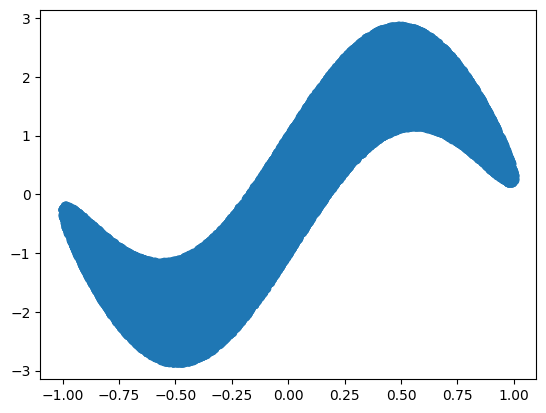

In [228]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [229]:
model_wave = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [258]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [265]:
scheduler.get_last_lr()

[0.044570040395095066]

In [266]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model_wave, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_wave, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:02, 28.87it/s]
62it [00:00, 101.47it/s]


Test set: Average loss: 68.3217


77it [00:02, 31.25it/s]
62it [00:00, 120.86it/s]


Test set: Average loss: 63.8686


77it [00:02, 31.24it/s]
62it [00:00, 123.01it/s]


Test set: Average loss: 62.4310


77it [00:02, 30.24it/s]
62it [00:00, 102.14it/s]


Test set: Average loss: 66.7982


77it [00:02, 31.45it/s]
62it [00:00, 127.57it/s]


Test set: Average loss: 65.4819


77it [00:02, 29.51it/s]
62it [00:00, 130.24it/s]


Test set: Average loss: 62.9752


77it [00:02, 30.56it/s]
62it [00:00, 126.01it/s]


Test set: Average loss: 63.7084


77it [00:02, 27.95it/s]
62it [00:00, 102.31it/s]


Test set: Average loss: 65.5007


77it [00:02, 27.74it/s]
62it [00:00, 101.31it/s]


Test set: Average loss: 65.2416


77it [00:02, 29.41it/s]
62it [00:00, 128.36it/s]


Test set: Average loss: 69.5855


77it [00:02, 30.26it/s]
62it [00:00, 106.34it/s]


Test set: Average loss: 63.7672


77it [00:02, 29.27it/s]
62it [00:00, 103.33it/s]


Test set: Average loss: 69.6475


77it [00:02, 27.98it/s]
62it [00:00, 103.67it/s]


Test set: Average loss: 60.8563


77it [00:02, 28.04it/s]
62it [00:00, 104.03it/s]


Test set: Average loss: 63.8930


77it [00:02, 27.82it/s]
62it [00:00, 125.93it/s]


Test set: Average loss: 64.8017


77it [00:02, 29.97it/s]
62it [00:00, 104.20it/s]


Test set: Average loss: 63.2724


77it [00:02, 28.05it/s]
62it [00:00, 103.67it/s]


Test set: Average loss: 68.3532


77it [00:02, 29.47it/s]
62it [00:00, 127.04it/s]


Test set: Average loss: 63.7686


77it [00:02, 31.03it/s]
62it [00:00, 129.16it/s]


Test set: Average loss: 63.4864


77it [00:02, 31.37it/s]
62it [00:00, 122.76it/s]

Test set: Average loss: 64.1172
CPU times: total: 1min 47s
Wall time: 1min 3s


[[1.01348173 1.58594758]
 [1.01283113 1.59278645]
 [1.01216702 1.59960388]
 ...
 [1.01474249 1.57220574]
 [1.01411885 1.57908733]
 [1.01348173 1.58594758]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\3606866717.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

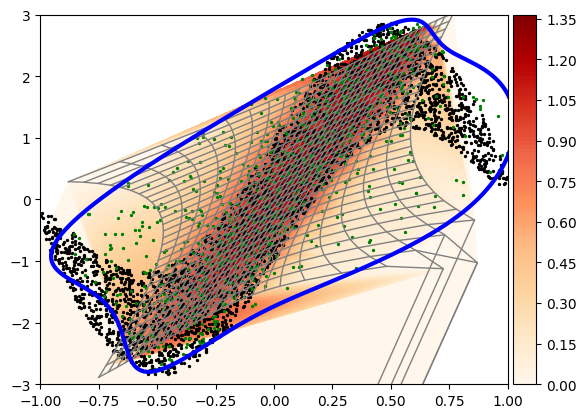

In [274]:
scale=1
factor=0.8

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1*scale,1*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)



## Starfish

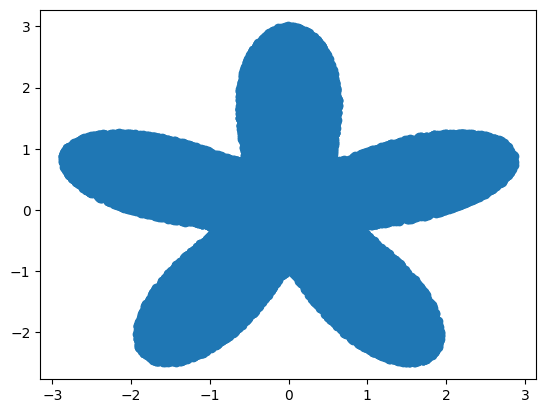

In [275]:
def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

training_set = generate_star(max_num=100000, n_edges=5, device=device)
validation_set = generate_star(max_num=10000, n_edges=5, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [371]:
model_star = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [372]:
optimizer = torch.optim.SGD(model_star.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [358]:
scheduler.get_last_lr()

[0.035848592240854196]

In [381]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model_star, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_star, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

39it [00:01, 25.76it/s]
32it [00:00, 101.27it/s]


Test set: Average loss: 263.6372


39it [00:01, 25.23it/s]
32it [00:00, 89.39it/s]


Test set: Average loss: 265.7030


39it [00:01, 24.72it/s]
32it [00:00, 85.11it/s]


Test set: Average loss: 268.4722


39it [00:01, 24.51it/s]
32it [00:00, 96.97it/s] 


Test set: Average loss: 262.7819


39it [00:01, 28.17it/s]
32it [00:00, 123.08it/s]


Test set: Average loss: 266.6043


39it [00:01, 31.20it/s]
32it [00:00, 125.97it/s]


Test set: Average loss: 265.7114


39it [00:01, 31.71it/s]
32it [00:00, 126.97it/s]


Test set: Average loss: 265.1077


39it [00:01, 30.78it/s]
32it [00:00, 129.02it/s]


Test set: Average loss: 263.0583


39it [00:01, 31.25it/s]
32it [00:00, 122.13it/s]


Test set: Average loss: 263.8233


39it [00:01, 27.96it/s]
32it [00:00, 107.01it/s]


Test set: Average loss: 262.4148


39it [00:01, 31.80it/s]
32it [00:00, 125.00it/s]


Test set: Average loss: 263.7858


39it [00:01, 28.00it/s]
32it [00:00, 87.42it/s]


Test set: Average loss: 262.7709


39it [00:01, 24.56it/s]
32it [00:00, 90.90it/s]


Test set: Average loss: 261.9281


39it [00:01, 24.51it/s]
32it [00:00, 89.89it/s]


Test set: Average loss: 261.8516


39it [00:01, 26.95it/s]
32it [00:00, 89.64it/s]


Test set: Average loss: 263.0263


39it [00:01, 24.58it/s]
32it [00:00, 85.78it/s]


Test set: Average loss: 261.7405


39it [00:01, 24.72it/s]
32it [00:00, 86.48it/s]


Test set: Average loss: 262.0940


39it [00:01, 26.69it/s]
32it [00:00, 91.69it/s]


Test set: Average loss: 261.7861


39it [00:01, 25.06it/s]
32it [00:00, 83.33it/s]


Test set: Average loss: 262.4716


39it [00:01, 25.28it/s]
32it [00:00, 86.25it/s]

Test set: Average loss: 261.3900
CPU times: total: 1min 14s
Wall time: 35.5 s


[[ 2.23812124 -0.47258609]
 [ 2.24149849 -0.46689117]
 [ 2.24486831 -0.46119736]
 ...
 [ 2.23134496 -0.4839793 ]
 [ 2.23473668 -0.47828214]
 [ 2.23812124 -0.47258609]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_3296\3606866717.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

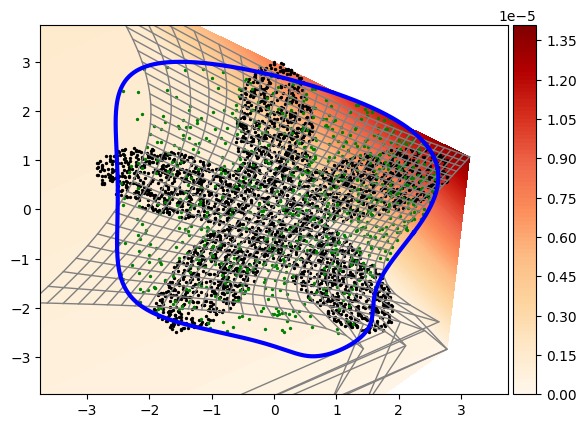

In [385]:
scale=15
factor=0.9

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_star, training_set.to('cpu'), device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.25*scale,0.25*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)